# Data Preparation for Larch Casebearer Dataset
Downloaded at [lila](https://lila.science/datasets/forest-damages-larch-casebearer/)

Swedish Forest Agency (2021): Forest Damages – Larch Casebearer 1.0. National Forest Data Lab. Dataset.

## Download and Extract Dataset

In [15]:
import os
import urllib.request
import zipfile
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.float_format = '{:,.2f}'.format
import shutil
import json
import xml.etree.ElementTree as ET

import seaborn as sns
sns.set_style("darkgrid")

In [16]:
# Define the base folder where the dataset resides
base_folder = "data"

# URL for downloading the dataset
zip_url="https://storage.googleapis.com/public-datasets-lila/larch-casebearer/Data_Set_Larch_Casebearer.zip"
zip_path = os.path.join(base_folder, "Data_Set_Larch_Casebearer.zip")


# Download the dataset
print("Downloading dataset...")
zip_path = "Data_Set_Larch_Casebearer.zip"
urllib.request.urlretrieve(zip_url, zip_path)

print("Extracting dataset...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(base_folder)

os.remove(zip_path)

Extracting dataset...


# Prepare DataFrame and Clean Up

In [17]:
# Initialize a list to store the data
data = []

original_dataset_path = os.path.join(base_folder, "Data_Set_Larch_Casebearer")

# Traverse through each location and date folder
for location_date_folder in os.listdir(original_dataset_path):
    location_date_path = os.path.join(original_dataset_path, location_date_folder)
    if not os.path.isdir(location_date_path):
        continue
    
    # Define paths for images and annotations
    annotations_folder = os.path.join(location_date_path, "Annotations")
    images_folder = os.path.join(location_date_path, "Images")
    
    # Get a list of available images and annotation files
    images_set = set(os.listdir(images_folder))
    annotations_set = set(os.listdir(annotations_folder))
    
    # Process each XML annotation file
    for xml_file in annotations_set:
        if not xml_file.endswith(".xml"):
            continue
        
        # Check if the corresponding image exists
        corresponding_image = xml_file.replace(".xml", ".JPG")
        if corresponding_image not in images_set:
            continue
        
        # Parse the XML file
        xml_path = os.path.join(annotations_folder, xml_file)
        tree = ET.parse(xml_path)
        root = tree.getroot()
        
        # Extract image metadata
        filename = root.find("filename").text if root.find("filename") is not None else None
        width = int(root.find("size/width").text) if root.find("size/width") is not None else None
        height = int(root.find("size/height").text) if root.find("size/height") is not None else None
        
        # Skip rows with missing or unknown data
        if not filename or "Unknown" in [filename]:
            continue
        if None in [width, height]:
            continue
        
        # Process each object in the annotation
        for obj in root.findall("object"):
            tree_type = obj.find("tree").text if obj.find("tree") is not None else None
            damage = obj.find("damage").text if obj.find("damage") is not None else None
            truncated = int(obj.find("truncated").text) if obj.find("truncated") is not None else None
            
            # Bounding box
            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text) if bbox is not None and bbox.find("xmin") is not None else None
            ymin = int(bbox.find("ymin").text) if bbox is not None and bbox.find("ymin") is not None else None
            xmax = int(bbox.find("xmax").text) if bbox is not None and bbox.find("xmax") is not None else None
            ymax = int(bbox.find("ymax").text) if bbox is not None and bbox.find("ymax") is not None else None
            
            # Skip rows with missing or unknown object data
            if None in [tree_type, damage, truncated, xmin, ymin, xmax, ymax]:
                continue
            if "Unknown" in [tree_type, damage]:
                continue
            
            # Add the data to the list
            data.append({
                "location_date": location_date_folder,
                "image_file": filename,
                "image_width": width,
                "image_height": height,
                "tree_type": tree_type,
                "damage": damage,
                "truncated": truncated,
                "xmin": xmin,
                "ymin": ymin,
                "xmax": xmax,
                "ymax": ymax
            })

# Create a DataFrame
df = pd.DataFrame(data)

# Drop duplicate rows
df = df.drop_duplicates()

# Reset the index
df = df.reset_index(drop=True)

# Change data types
df = df.astype({
    "truncated": int,
    "xmin": int,
    "ymin": int,
    "xmax": int,
    "ymax": int
})

In [18]:
df

,location_date,image_file,image_width,image_height,tree_type,damage,truncated,xmin,ymin,xmax,ymax
0,Bebehojd_20190527,B01_0170.JPG,1500,1500,Larch,HD,0,520,1213,661,1334
1,Bebehojd_20190527,B01_0170.JPG,1500,1500,Larch,HD,0,601,1330,734,1448
2,Bebehojd_20190527,B01_0170.JPG,1500,1500,Larch,LD,0,907,1359,989,1469
3,Bebehojd_20190527,B01_0170.JPG,1500,1500,Larch,HD,0,884,819,1003,969
4,Bebehojd_20190527,B01_0170.JPG,1500,1500,Larch,HD,0,1012,778,1118,894
...,...,...,...,...,...,...,...,...,...,...,...
101828,Nordkap_20190819,B10_0027.JPG,1500,1500,Other,other,0,436,188,842,685
101829,Nordkap_20190819,B10_0027.JPG,1500,1500,Other,other,1,1,235,377,691
101830,Nordkap_20190819,B10_0027.JPG,1500,1500,Other,other,0,844,81,1288,539
101831,Nordkap_20190819,B10_0027.JPG,1500,1500,Other,other,1,1259,1,1500,542


# Visualize Data from May

In [19]:
# Filter data for May month
may_data = df[df['location_date'].str.contains('_201905')].copy()

# Extract locations from the location_date column
may_data['location'] = may_data['location_date'].str.split('_').str[0]

# Count occurrences of each damage type for each location
damage_counts = may_data.groupby(['location', 'damage']).size().unstack(fill_value=0)

# Calculate total images for each location
total_images = may_data.groupby('location')['image_file'].nunique()

# Calculate total annotations for each location
total_annotations = damage_counts.sum(axis=1)

# Add percentages to the table
damage_percentages = damage_counts.div(damage_counts.sum(axis=1), axis=0) * 100
damage_table = damage_counts.copy()
for col in damage_counts.columns:
    damage_table[col + ' (%)'] = damage_percentages[col]

# Add total images and total annotations to the table
damage_table.insert(0, 'Total Images', total_images)
damage_table.insert(1, 'Total Annotations', total_annotations)

In [20]:
damage_table

damage,Total Images,Total Annotations,H,HD,LD,other,H (%),HD (%),LD (%),other (%)
location,,,,,,,,,,
Bebehojd,171,11306,142,2326,6277,2561,1.26,20.57,55.52,22.65
Ekbacka,214,9125,327,970,5126,2702,3.58,10.63,56.18,29.61
Jallasvag,49,3082,212,502,1743,625,6.88,16.29,56.55,20.28
Kampe,178,18469,1469,3001,11483,2516,7.95,16.25,62.17,13.62
Nordkap,223,14428,488,2285,8668,2987,3.38,15.84,60.08,20.70


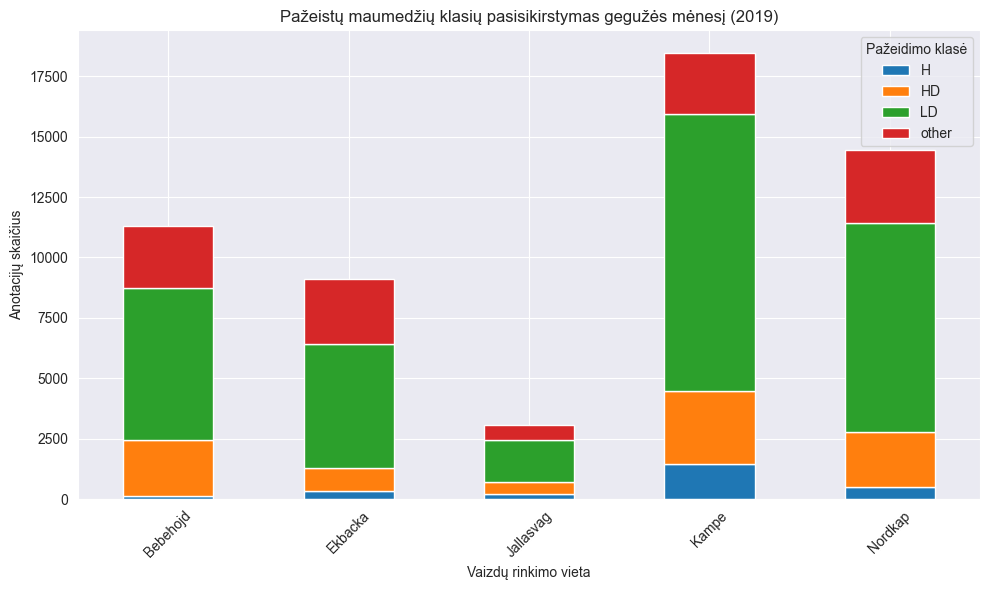

In [21]:
# Plotting the barplot
damage_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Pažeistų maumedžių klasių pasisikirstymas gegužės mėnesį (2019)')
plt.ylabel('Anotacijų skaičius')
plt.xlabel('Vaizdų rinkimo vieta')
plt.legend(title='Pažeidimo klasė')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Convert Data for Object Detection

In [27]:
# Define the split
train_locations = ["Bebehojd", "Ekbacka", "Kampe"]
val_locations = ["Jallasvag"]
test_locations = ["Nordkap"]

# Define the main output folder
output_base = os.path.join(base_folder, "larch_casebearer")
os.makedirs(output_base, exist_ok=True)

# Define damage type to category ID mapping
damage_to_category = {"H": 1, "LD": 2, "HD": 3, "other": 4}
categories = [{"id": 1, "name": "H", "supercategory": "damage"},
              {"id": 2, "name": "LD", "supercategory": "damage"},
              {"id": 3, "name": "HD", "supercategory": "damage"},
              {"id": 4, "name": "other", "supercategory": "damage"}]

# Helper function to process and convert data for each subset
def process_subset(locations, subset_name):
    subset_folder = os.path.join(output_base, subset_name)
    os.makedirs(subset_folder, exist_ok=True)
    
    # Initialize COCO structure
    coco_data = {
        "images": [],
        "annotations": [],
        "categories": categories
    }
    annotation_id = 0
    
    # Process each location
    for location in locations:
        for _, row in may_data[may_data['location'] == location].iterrows():
            # Copy image file directly to subset folder
            img_src = os.path.join("data\\Data_Set_Larch_Casebearer", row["location_date"], "Images", row["image_file"])
            img_dst = os.path.join(subset_folder, row["image_file"])
            
            if not os.path.exists(img_dst):
                shutil.copy(img_src, img_dst)
            
            # Process XML annotation
            ann_src = os.path.join("data\\Data_Set_Larch_Casebearer", row["location_date"], "Annotations", row["image_file"].replace(".JPG", ".xml"))
            
            # Get valid objects for this image from the DataFrame
            valid_objects = may_data[
                (may_data["image_file"] == row["image_file"]) & 
                (may_data["location_date"] == row["location_date"])
            ][["tree_type", "damage", "xmin", "ymin", "xmax", "ymax"]].to_dict("records")
            
            # Convert XML to COCO format
            if os.path.exists(ann_src):
                tree = ET.parse(ann_src)
                root = tree.getroot()
                
                # Image metadata
                filename = root.find("filename").text
                width = int(root.find("size/width").text)
                height = int(root.find("size/height").text)
                
                # Check if this image is already added
                image_id = None
                for img in coco_data["images"]:
                    if img["file_name"] == filename:
                        image_id = img["id"]
                        break
                
                if image_id is None:
                    image_id = len(coco_data["images"])
                    coco_data["images"].append({
                        "id": image_id,
                        "file_name": filename,
                        "width": width,
                        "height": height
                    })
                
                # Parse objects and filter based on valid_objects
                for obj in root.findall("object"):
                    tree_type = obj.find("tree").text if obj.find("tree") is not None else None
                    damage = obj.find("damage").text if obj.find("damage") is not None else None
                    bbox = obj.find("bndbox")
                    
                    if bbox is not None:
                        xmin = int(bbox.find("xmin").text) if bbox.find("xmin") is not None else None
                        ymin = int(bbox.find("ymin").text) if bbox.find("ymin") is not None else None
                        xmax = int(bbox.find("xmax").text) if bbox.find("xmax") is not None else None
                        ymax = int(bbox.find("ymax").text) if bbox.find("ymax") is not None else None
                        
                        # Check if this object is in valid_objects
                        is_valid = any(
                            (o["tree_type"] == tree_type and o["damage"] == damage and 
                             o["xmin"] == xmin and o["ymin"] == ymin and 
                             o["xmax"] == xmax and o["ymax"] == ymax)
                            for o in valid_objects
                        )
                        
                        if is_valid and damage in damage_to_category:
                            # COCO bbox format: [x, y, width, height]
                            bbox_coco = [xmin, ymin, xmax - xmin, ymax - ymin]
                            area = bbox_coco[2] * bbox_coco[3]
                            
                            coco_data["annotations"].append({
                                "id": annotation_id,
                                "image_id": image_id,
                                "category_id": damage_to_category[damage],
                                "bbox": bbox_coco,
                                "area": area,
                                "iscrowd": 0
                            })
                            annotation_id += 1
    
    # Save COCO JSON file as annotations.json
    with open(os.path.join(subset_folder, "annotations.json"), "w") as f:
        json.dump(coco_data, f, indent=4)
    
    print(f"{subset_name} data processed: {len(coco_data['images'])} images, {len(coco_data['annotations'])} annotations")

# Process each subset
process_subset(train_locations, "train")
process_subset(val_locations, "val")
process_subset(test_locations, "test")

print(f"Dataset successfully created in '{output_base}' folder with COCO annotations.")

train data processed: 563 images, 3371453 annotations
val data processed: 49 images, 233576 annotations
test data processed: 223 images, 1044378 annotations
Dataset successfully created in 'data\larch_casebearer' folder with COCO annotations.
